In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import scipy
from scipy import io

Mnist data loading 

In [5]:
mat = io.loadmat('./data_image_classif.mat')

X = mat['Xts']

df_y = pd.DataFrame(mat['yts'])
y = pd.get_dummies(df_y[0]).to_numpy() # OneHotEncoding
print(f'y shape : {y.shape}')

X_to_predict = pd.DataFrame(mat['Xvr'])

y shape : (60000, 10)


Documents data loading

In [6]:
mat_doc = io.loadmat('./data_doc_classif.mat')

X_doc = mat_doc['Xts'].T.toarray()

df_y_doc = pd.DataFrame(mat_doc['yts'])
y_doc = pd.get_dummies(df_y_doc[0]).to_numpy() # OneHotEncoding
print(f'y shape : {y_doc.shape}')

X_to_predict_doc = pd.DataFrame(mat_doc['Xvr'].T.toarray())



y shape : (13960, 20)


Documents train set

In [7]:
train_set_doc = [[X_doc[i].reshape(1,-1),y_doc[i].reshape(1,-1)] for i in range(X_doc.shape[0])]
len(train_set_doc)

13960

Mnist train set

In [8]:
train_set = [[X[i].reshape(1,-1),y[i].reshape(1,-1)] for i in range(X.shape[0])]
len(train_set)

60000

Functions init

In [9]:
def sig(x):
    
    return 1/(1 + np.exp(-x))

def sig_der(x):
    
    return sig(x)*(1 - sig(x))

def loss(y, y_pred):
    
    return ((y-y_pred)**2).mean()


def loss_batch(y, y_pred):
    
    return np.mean(np.mean(((y-y_pred)**2), axis = 1))



def relu_deriv(t):
    
    return (t >= 0).astype(float)

def relu(t):
    return np.maximum(t,0)

# accuracy
def accuracy(cur_set):
    correct = 0
    
    for x,y in cur_set:
        z = predict_new3(x)
        y_pred = np.argmax(z)
        if y_pred == np.argmax(y):
            correct += 1
#         print(y_pred, np.argmax(y))
    acc = correct / len(cur_set)
    return acc

def accuracy_doc(cur_set, y = None):
    correct = 0
    
    for x,y in cur_set:
        z = predict_new3_doc(x)
        y_pred = np.argmax(z)
        if y_pred == np.argmax(y):
            correct += 1
#         print(y_pred, np.argmax(y))
    acc = correct / len(cur_set)
    return acc

def softmax(t):
    
    out = np.exp(t)
    return out/np.sum(out)

def softmax_batch(t):
    
    out = np.exp(t)
    return out/np.sum(out, axis = 1, keepdims = True)

def stable_softmax(x):
    z = x - np.max(x, axis = 1, keepdims = True)
    numerator = np.exp(z)
    denominator = np.sum(numerator, axis = 1, keepdims = True)
    softmax = numerator/denominator

    return softmax

def predict_new(x):
    s1 = np.dot(x, W1) + b1
    h1 = relu(s1)

    y_pred = stable_softmax(h1 @ W2 + b2)
    return y_pred

def predict_new3(x):
    s1 = np.dot(x, W1) + b1
    h1 = relu(s1)
    
    s2 = h1 @ W2 + b2
    h2 = relu(s2)

    y_pred = stable_softmax(h2 @ W3 + b3)
    return y_pred

def predict_new3_doc(x):
    s1 = np.dot(x, W1_doc) + b1_doc
    h1 = relu(s1)
    
    s2 = h1 @ W2_doc + b2_doc
    h2 = relu(s2)

    y_pred = stable_softmax(h2 @ W3_doc + b3_doc)
    return y_pred

def soft_deriv(x):

   return stable_softmax(x) * (1 - stable_softmax(x))

Model for prediction the documents

In [11]:
input_size_doc = X_doc.shape[1]
hidden_size1_doc = 500
hidden_size2_doc = 500
output_size_doc = 20
batch_size_doc = 500



W1_doc = np.random.randn(input_size_doc, hidden_size1_doc)
b1_doc = np.random.randn(1, hidden_size1_doc)

W2_doc = np.random.randn(hidden_size1_doc, hidden_size2_doc)
b2_doc = np.random.randn(1, hidden_size2_doc)

W3_doc = np.random.randn(hidden_size2_doc, output_size_doc)
b3_doc = np.random.randn(1, output_size_doc)


loss_list_doc = []

n_iters_batch_doc = len(train_set_doc) // batch_size_doc
learning_rate_doc = 0.01
n_epochs_doc = 30

status_l = True

random.shuffle(train_set_doc) 

for ep in range(n_epochs_doc):
    
    for i in range(n_iters_batch_doc):
        
        
        batch_x, batch_y = zip(*train_set_doc[i*batch_size_doc: (i+1)*batch_size_doc])
        x = np.concatenate(batch_x, axis = 0)
        y = np.concatenate(batch_y, axis = 0)
        
        s1 = np.dot(x, W1_doc) + b1_doc
        h1 = relu(s1)
        
        s2 = h1 @ W2_doc + b2_doc
        h2 = relu(s2)

        y_pred = stable_softmax(h2 @ W3_doc + b3_doc)
        
        
        
        E = loss_batch(y_pred, y)
        loss_list_doc.append(E)
        
        
        # backward pass
        
        # 3 layer
 
        dloss_dS3  = 2*(y_pred - y)/batch_size_doc  #dloss / y_pred 
        
        dloss_dW3 = h2.T @ dloss_dS3
        
        dloss_db3 = np.sum(dloss_dS3, axis = 0, keepdims = True)
        
        dloss_dh2 = dloss_dS3 @ W3_doc.T

        # 2 layer
 
        dloss_dS2  = dloss_dh2*relu_deriv(s2)  #dloss / y_pred 
        
        dloss_dW2 = h1.T @ dloss_dS2
        
        dloss_db2 = np.sum(dloss_dS2, axis = 0, keepdims = True)
        
        dloss_dh1 = dloss_dS2 @ W2_doc.T
        
        # 1 layer
        dloss_dS1  = dloss_dh1*relu_deriv(s1)
        
        dloss_dW1 = x.T @ dloss_dS1
        
        dloss_db1 = np.sum(dloss_dS1, axis = 0, keepdims=True)
        
        W1_doc -= learning_rate_doc *dloss_dW1
        b1_doc -= learning_rate_doc *dloss_db1
        W2_doc -= learning_rate_doc *dloss_dW2
        b2_doc -= learning_rate_doc *dloss_db2
        W3_doc -= learning_rate_doc *dloss_dW3
        b3_doc -= learning_rate_doc *dloss_db3
    
        
#         if l < 1.91 and status_l:
#             learning_rate = 0.01
#             status_l = False
#             print(learning_rate)

        print(f'ep: {ep+1}/{n_epochs_doc}, i: {i+1}/{n_iters_batch_doc}, '
              f'loss - {E:.3f}, ' 
              f'norm_W - {np.linalg.norm(W1_doc):.3f}, ' 
              f'norm_dw - {np.linalg.norm(dloss_dW1):.3f}')
    # if ep == 4:
    #   learning_rate = 10
    # print(f'accuracy - {accuracy(train_set)}')
          





ep: 1/30, i: 1/27, loss - 0.094, norm_W - 4668.867, norm_dw - 515.730
ep: 1/30, i: 2/27, loss - 0.095, norm_W - 4668.833, norm_dw - 769.420
ep: 1/30, i: 3/27, loss - 0.094, norm_W - 4668.790, norm_dw - 671.779
ep: 1/30, i: 4/27, loss - 0.094, norm_W - 4668.763, norm_dw - 589.795
ep: 1/30, i: 5/27, loss - 0.092, norm_W - 4668.742, norm_dw - 412.313
ep: 1/30, i: 6/27, loss - 0.093, norm_W - 4668.728, norm_dw - 342.423
ep: 1/30, i: 7/27, loss - 0.088, norm_W - 4668.719, norm_dw - 296.964
ep: 1/30, i: 8/27, loss - 0.090, norm_W - 4668.712, norm_dw - 537.279
ep: 1/30, i: 9/27, loss - 0.086, norm_W - 4668.706, norm_dw - 326.016
ep: 1/30, i: 10/27, loss - 0.089, norm_W - 4668.701, norm_dw - 351.509
ep: 1/30, i: 11/27, loss - 0.083, norm_W - 4668.696, norm_dw - 289.670
ep: 1/30, i: 12/27, loss - 0.084, norm_W - 4668.691, norm_dw - 238.627
ep: 1/30, i: 13/27, loss - 0.083, norm_W - 4668.688, norm_dw - 404.320
ep: 1/30, i: 14/27, loss - 0.083, norm_W - 4668.684, norm_dw - 337.415
ep: 1/30, i: 15

ep: 5/30, i: 10/27, loss - 0.048, norm_W - 4668.538, norm_dw - 76.238
ep: 5/30, i: 11/27, loss - 0.043, norm_W - 4668.538, norm_dw - 62.810
ep: 5/30, i: 12/27, loss - 0.048, norm_W - 4668.537, norm_dw - 68.094
ep: 5/30, i: 13/27, loss - 0.047, norm_W - 4668.537, norm_dw - 69.325
ep: 5/30, i: 14/27, loss - 0.045, norm_W - 4668.536, norm_dw - 65.220
ep: 5/30, i: 15/27, loss - 0.045, norm_W - 4668.536, norm_dw - 66.106
ep: 5/30, i: 16/27, loss - 0.051, norm_W - 4668.535, norm_dw - 72.429
ep: 5/30, i: 17/27, loss - 0.049, norm_W - 4668.535, norm_dw - 67.275
ep: 5/30, i: 18/27, loss - 0.048, norm_W - 4668.534, norm_dw - 68.587
ep: 5/30, i: 19/27, loss - 0.045, norm_W - 4668.534, norm_dw - 62.499
ep: 5/30, i: 20/27, loss - 0.045, norm_W - 4668.533, norm_dw - 71.131
ep: 5/30, i: 21/27, loss - 0.049, norm_W - 4668.533, norm_dw - 66.866
ep: 5/30, i: 22/27, loss - 0.048, norm_W - 4668.532, norm_dw - 68.821
ep: 5/30, i: 23/27, loss - 0.054, norm_W - 4668.531, norm_dw - 67.172
ep: 5/30, i: 24/27, 

ep: 9/30, i: 20/27, loss - 0.030, norm_W - 4668.498, norm_dw - 48.387
ep: 9/30, i: 21/27, loss - 0.033, norm_W - 4668.498, norm_dw - 46.513
ep: 9/30, i: 22/27, loss - 0.031, norm_W - 4668.498, norm_dw - 42.198
ep: 9/30, i: 23/27, loss - 0.035, norm_W - 4668.497, norm_dw - 49.173
ep: 9/30, i: 24/27, loss - 0.036, norm_W - 4668.497, norm_dw - 50.847
ep: 9/30, i: 25/27, loss - 0.032, norm_W - 4668.497, norm_dw - 46.010
ep: 9/30, i: 26/27, loss - 0.028, norm_W - 4668.497, norm_dw - 40.788
ep: 9/30, i: 27/27, loss - 0.031, norm_W - 4668.496, norm_dw - 41.611
ep: 10/30, i: 1/27, loss - 0.024, norm_W - 4668.496, norm_dw - 35.512
ep: 10/30, i: 2/27, loss - 0.028, norm_W - 4668.496, norm_dw - 46.681
ep: 10/30, i: 3/27, loss - 0.027, norm_W - 4668.496, norm_dw - 38.778
ep: 10/30, i: 4/27, loss - 0.032, norm_W - 4668.496, norm_dw - 44.906
ep: 10/30, i: 5/27, loss - 0.031, norm_W - 4668.496, norm_dw - 41.655
ep: 10/30, i: 6/27, loss - 0.028, norm_W - 4668.495, norm_dw - 40.256
ep: 10/30, i: 7/27, 

ep: 14/30, i: 2/27, loss - 0.021, norm_W - 4668.481, norm_dw - 37.769
ep: 14/30, i: 3/27, loss - 0.017, norm_W - 4668.481, norm_dw - 30.972
ep: 14/30, i: 4/27, loss - 0.023, norm_W - 4668.481, norm_dw - 33.186
ep: 14/30, i: 5/27, loss - 0.021, norm_W - 4668.481, norm_dw - 31.339
ep: 14/30, i: 6/27, loss - 0.020, norm_W - 4668.481, norm_dw - 31.621
ep: 14/30, i: 7/27, loss - 0.021, norm_W - 4668.481, norm_dw - 31.723
ep: 14/30, i: 8/27, loss - 0.018, norm_W - 4668.481, norm_dw - 31.924
ep: 14/30, i: 9/27, loss - 0.020, norm_W - 4668.481, norm_dw - 29.554
ep: 14/30, i: 10/27, loss - 0.020, norm_W - 4668.481, norm_dw - 38.090
ep: 14/30, i: 11/27, loss - 0.020, norm_W - 4668.480, norm_dw - 36.977
ep: 14/30, i: 12/27, loss - 0.018, norm_W - 4668.480, norm_dw - 37.897
ep: 14/30, i: 13/27, loss - 0.018, norm_W - 4668.480, norm_dw - 32.202
ep: 14/30, i: 14/27, loss - 0.019, norm_W - 4668.480, norm_dw - 28.889
ep: 14/30, i: 15/27, loss - 0.019, norm_W - 4668.480, norm_dw - 36.242
ep: 14/30, i: 

ep: 18/30, i: 11/27, loss - 0.014, norm_W - 4668.473, norm_dw - 26.873
ep: 18/30, i: 12/27, loss - 0.015, norm_W - 4668.473, norm_dw - 34.002
ep: 18/30, i: 13/27, loss - 0.013, norm_W - 4668.473, norm_dw - 27.202
ep: 18/30, i: 14/27, loss - 0.015, norm_W - 4668.473, norm_dw - 23.383
ep: 18/30, i: 15/27, loss - 0.013, norm_W - 4668.472, norm_dw - 31.453
ep: 18/30, i: 16/27, loss - 0.014, norm_W - 4668.472, norm_dw - 22.686
ep: 18/30, i: 17/27, loss - 0.013, norm_W - 4668.472, norm_dw - 22.105
ep: 18/30, i: 18/27, loss - 0.013, norm_W - 4668.472, norm_dw - 28.089
ep: 18/30, i: 19/27, loss - 0.016, norm_W - 4668.472, norm_dw - 28.160
ep: 18/30, i: 20/27, loss - 0.014, norm_W - 4668.472, norm_dw - 32.782
ep: 18/30, i: 21/27, loss - 0.017, norm_W - 4668.472, norm_dw - 31.061
ep: 18/30, i: 22/27, loss - 0.015, norm_W - 4668.472, norm_dw - 25.950
ep: 18/30, i: 23/27, loss - 0.016, norm_W - 4668.472, norm_dw - 29.450
ep: 18/30, i: 24/27, loss - 0.016, norm_W - 4668.472, norm_dw - 34.000
ep: 18

ep: 22/30, i: 19/27, loss - 0.012, norm_W - 4668.467, norm_dw - 24.266
ep: 22/30, i: 20/27, loss - 0.013, norm_W - 4668.467, norm_dw - 41.641
ep: 22/30, i: 21/27, loss - 0.014, norm_W - 4668.467, norm_dw - 28.922
ep: 22/30, i: 22/27, loss - 0.013, norm_W - 4668.467, norm_dw - 24.997
ep: 22/30, i: 23/27, loss - 0.013, norm_W - 4668.467, norm_dw - 27.898
ep: 22/30, i: 24/27, loss - 0.014, norm_W - 4668.467, norm_dw - 31.323
ep: 22/30, i: 25/27, loss - 0.013, norm_W - 4668.467, norm_dw - 26.811
ep: 22/30, i: 26/27, loss - 0.011, norm_W - 4668.467, norm_dw - 22.347
ep: 22/30, i: 27/27, loss - 0.012, norm_W - 4668.467, norm_dw - 24.172
ep: 23/30, i: 1/27, loss - 0.011, norm_W - 4668.467, norm_dw - 24.535
ep: 23/30, i: 2/27, loss - 0.011, norm_W - 4668.467, norm_dw - 31.266
ep: 23/30, i: 3/27, loss - 0.011, norm_W - 4668.467, norm_dw - 25.682
ep: 23/30, i: 4/27, loss - 0.013, norm_W - 4668.467, norm_dw - 26.590
ep: 23/30, i: 5/27, loss - 0.012, norm_W - 4668.467, norm_dw - 23.838
ep: 23/30, 

ep: 26/30, i: 27/27, loss - 0.008, norm_W - 4668.464, norm_dw - 19.937
ep: 27/30, i: 1/27, loss - 0.008, norm_W - 4668.464, norm_dw - 20.630
ep: 27/30, i: 2/27, loss - 0.008, norm_W - 4668.464, norm_dw - 28.216
ep: 27/30, i: 3/27, loss - 0.009, norm_W - 4668.464, norm_dw - 24.460
ep: 27/30, i: 4/27, loss - 0.009, norm_W - 4668.464, norm_dw - 22.945
ep: 27/30, i: 5/27, loss - 0.010, norm_W - 4668.464, norm_dw - 23.458
ep: 27/30, i: 6/27, loss - 0.008, norm_W - 4668.464, norm_dw - 23.911
ep: 27/30, i: 7/27, loss - 0.010, norm_W - 4668.464, norm_dw - 23.760
ep: 27/30, i: 8/27, loss - 0.009, norm_W - 4668.464, norm_dw - 22.663
ep: 27/30, i: 9/27, loss - 0.007, norm_W - 4668.464, norm_dw - 16.885
ep: 27/30, i: 10/27, loss - 0.009, norm_W - 4668.464, norm_dw - 30.209
ep: 27/30, i: 11/27, loss - 0.010, norm_W - 4668.464, norm_dw - 25.652
ep: 27/30, i: 12/27, loss - 0.009, norm_W - 4668.464, norm_dw - 29.973
ep: 27/30, i: 13/27, loss - 0.009, norm_W - 4668.464, norm_dw - 24.764
ep: 27/30, i: 1

In [12]:
accuracy_doc(train_set_doc[:5000])

0.908

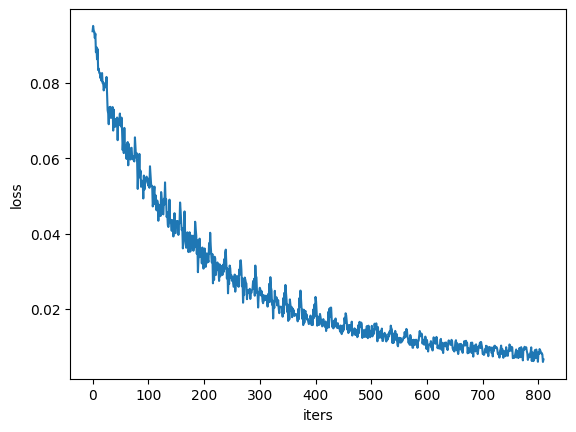

In [14]:
plt.plot(loss_list_doc)
plt.xlabel('iters')
plt.ylabel('loss')
plt.show()

In [115]:
X_to_predict_array_doc = X_to_predict_doc.values
X_to_predict_array_doc.shape

(5989, 43586)

In [125]:
y_predict_doc = []
for i in range(len(X_to_predict_array_doc)):
    y_predict_doc.append(np.argmax(predict_new3_doc(X_to_predict_array_doc[i].reshape(1,-1))))

In [137]:
y_predict_new_doc = [y_predict_doc[i]*100+1 for i in range(len(y_predict_doc))]

In [138]:
y_predict_new_doc_df = pd.DataFrame(np.array(y_predict_new_doc))

In [142]:
df = pd.read_csv('sol_all1.csv')

In [143]:
df

,id,class
0,1,101
1,2,101
2,3,101
3,4,101
4,5,101
...,...,...
5984,5985,101
5985,5986,101
5986,5987,101
5987,5988,101


In [144]:
y_predict_new_doc_df['id'] = df.id

In [145]:
y_predict_new_doc_df['class'] = y_predict_new_doc_df.iloc[:,0]

In [146]:
y_predict_new_doc_df.rename(columns = {0: 'class'}, inplace = True)

In [147]:
y_predict_new_doc_df = y_predict_new_doc_df[['id', 'class']]

In [148]:
y_predict_new_doc_df = y_predict_new_doc_df.iloc[:,:-1]

In [149]:
y_predict_new_doc_df

,id,class
0,1,1301
1,2,1701
2,3,601
3,4,101
4,5,201
...,...,...
5984,5985,401
5985,5986,1201
5986,5987,201
5987,5988,1901


In [151]:
y_predict_new_doc_df.to_csv('Skripkin_doc.csv', index = False)

In [154]:
pd.read_csv('Skripkin_doc.csv')

,id,class
0,1,1301
1,2,1701
2,3,601
3,4,101
4,5,201
...,...,...
5984,5985,401
5985,5986,1201
5986,5987,201
5987,5988,1901


In [155]:
train_set[0][0].shape

(1, 784)

In [19]:
input_size = X.shape[1]
hidden_size1 = 392
hidden_size2 = 100
output_size = y.shape[1]
batch_size = int(X.shape[0] / 3)



W1 = np.random.randn(input_size, hidden_size1)
b1 = np.random.randn(1, hidden_size1)

W2 = np.random.randn(hidden_size1, hidden_size2)
b2 = np.random.randn(1, hidden_size2)

W3 = np.random.randn(hidden_size2, output_size)
b3 = np.random.randn(1, output_size)


loss_list = []
acc_list = []

n_iters_batch = len(train_set) // batch_size

learning_rate = 0.00001

n_epochs = 100

status_l = True

random.shuffle(train_set) 

for ep in range(n_epochs):
    
    for i in range(n_iters_batch):
        
        
        batch_x, batch_y = zip(*train_set[i*batch_size: (i+1)*batch_size])
        x = np.concatenate(batch_x, axis = 0)
        y = np.concatenate(batch_y, axis = 0)
        
        s1 = np.dot(x, W1) + b1
        h1 = relu(s1)
        
        s2 = h1 @ W2 + b2
        h2 = relu(s2)

        # s3 = h2 @ W3 + b3
        # h3 = relu(s3)

        y_pred = stable_softmax(h2 @ W3 + b3)
        
        
        
        E = loss_batch(y_pred, y)
        loss_list.append(E)
        
        
        # 3 layer
      
        dloss_dS3  = 2*(y_pred - y)/batch_size  #dloss / y_pred 

        dloss_dW3 = h2.T @ dloss_dS3
        
        dloss_db3 = np.sum(dloss_dS3, axis = 0, keepdims = True)
        
        dloss_dh2 = dloss_dS3 @ W3.T

        # 2 layer
 
        dloss_dS2  = dloss_dh2*relu_deriv(s2)  #dloss / y_pred 
        
        dloss_dW2 = h1.T @ dloss_dS2
        
        dloss_db2 = np.sum(dloss_dS2, axis = 0, keepdims = True)
        
        dloss_dh1 = dloss_dS2 @ W2.T
        
        # 1 layer
        dloss_dS1  = dloss_dh1*relu_deriv(s1)
        
        dloss_dW1 = x.T @ dloss_dS1
        
        dloss_db1 = np.sum(dloss_dS1, axis = 0, keepdims=True)
        
        W1 -= learning_rate *dloss_dW1
        b1 -= learning_rate *dloss_db1
        W2 -= learning_rate *dloss_dW2
        b2 -= learning_rate *dloss_db2
        W3 -= learning_rate *dloss_dW3
        b3 -= learning_rate *dloss_db3
        # W4 -= learning_rate *dloss_dW4
        # b4 -= learning_rate *dloss_db4
    
        
#         if l < 1.91 and status_l:
#             learning_rate = 0.01
#             status_l = False
#             print(learning_rate)

        print(f'ep: {ep+1}/{n_epochs}, i: {i+1}/{n_iters_batch}, '
              f'loss - {E:.3f}, ' 
              f'norm_W - {np.linalg.norm(W1):.3f}, ' 
              f'norm_dw - {np.linalg.norm(dloss_dW1):.3f}')
    # if ep == 4:
    #   learning_rate = 10
    # print(f'accuracy - {accuracy(train_set)}')
          





ep: 1/100, i: 1/3, loss - 0.174, norm_W - 554.091, norm_dw - 100410.538
ep: 1/100, i: 2/3, loss - 0.175, norm_W - 554.084, norm_dw - 60508.226
ep: 1/100, i: 3/3, loss - 0.171, norm_W - 554.079, norm_dw - 49894.098
ep: 2/100, i: 1/3, loss - 0.159, norm_W - 554.074, norm_dw - 37882.920
ep: 2/100, i: 2/3, loss - 0.150, norm_W - 554.071, norm_dw - 31648.321
ep: 2/100, i: 3/3, loss - 0.142, norm_W - 554.067, norm_dw - 28316.935
ep: 3/100, i: 1/3, loss - 0.135, norm_W - 554.065, norm_dw - 24444.925
ep: 3/100, i: 2/3, loss - 0.129, norm_W - 554.062, norm_dw - 22240.558
ep: 3/100, i: 3/3, loss - 0.123, norm_W - 554.059, norm_dw - 20017.303
ep: 4/100, i: 1/3, loss - 0.118, norm_W - 554.057, norm_dw - 18230.234
ep: 4/100, i: 2/3, loss - 0.114, norm_W - 554.055, norm_dw - 17181.148
ep: 4/100, i: 3/3, loss - 0.110, norm_W - 554.053, norm_dw - 15855.954
ep: 5/100, i: 1/3, loss - 0.107, norm_W - 554.051, norm_dw - 14756.614
ep: 5/100, i: 2/3, loss - 0.102, norm_W - 554.049, norm_dw - 14005.621
ep: 5

ep: 39/100, i: 3/3, loss - 0.044, norm_W - 553.967, norm_dw - 2567.993
ep: 40/100, i: 1/3, loss - 0.043, norm_W - 553.967, norm_dw - 2581.846
ep: 40/100, i: 2/3, loss - 0.043, norm_W - 553.966, norm_dw - 2532.237
ep: 40/100, i: 3/3, loss - 0.044, norm_W - 553.966, norm_dw - 2524.584
ep: 41/100, i: 1/3, loss - 0.043, norm_W - 553.965, norm_dw - 2550.368
ep: 41/100, i: 2/3, loss - 0.043, norm_W - 553.965, norm_dw - 2486.515
ep: 41/100, i: 3/3, loss - 0.043, norm_W - 553.965, norm_dw - 2487.753
ep: 42/100, i: 1/3, loss - 0.043, norm_W - 553.964, norm_dw - 2516.041
ep: 42/100, i: 2/3, loss - 0.043, norm_W - 553.964, norm_dw - 2439.728
ep: 42/100, i: 3/3, loss - 0.043, norm_W - 553.963, norm_dw - 2435.687
ep: 43/100, i: 1/3, loss - 0.042, norm_W - 553.963, norm_dw - 2457.508
ep: 43/100, i: 2/3, loss - 0.042, norm_W - 553.962, norm_dw - 2398.602
ep: 43/100, i: 3/3, loss - 0.043, norm_W - 553.962, norm_dw - 2392.056
ep: 44/100, i: 1/3, loss - 0.042, norm_W - 553.961, norm_dw - 2428.721
ep: 44

ep: 78/100, i: 2/3, loss - 0.035, norm_W - 553.923, norm_dw - 1582.414
ep: 78/100, i: 3/3, loss - 0.035, norm_W - 553.923, norm_dw - 1578.792
ep: 79/100, i: 1/3, loss - 0.034, norm_W - 553.922, norm_dw - 1598.140
ep: 79/100, i: 2/3, loss - 0.034, norm_W - 553.922, norm_dw - 1577.627
ep: 79/100, i: 3/3, loss - 0.035, norm_W - 553.922, norm_dw - 1569.132
ep: 80/100, i: 1/3, loss - 0.034, norm_W - 553.922, norm_dw - 1591.937
ep: 80/100, i: 2/3, loss - 0.034, norm_W - 553.921, norm_dw - 1563.640
ep: 80/100, i: 3/3, loss - 0.035, norm_W - 553.921, norm_dw - 1563.912
ep: 81/100, i: 1/3, loss - 0.034, norm_W - 553.921, norm_dw - 1561.901
ep: 81/100, i: 2/3, loss - 0.034, norm_W - 553.920, norm_dw - 1545.751
ep: 81/100, i: 3/3, loss - 0.035, norm_W - 553.920, norm_dw - 1545.236
ep: 82/100, i: 1/3, loss - 0.034, norm_W - 553.920, norm_dw - 1556.259
ep: 82/100, i: 2/3, loss - 0.034, norm_W - 553.919, norm_dw - 1536.782
ep: 82/100, i: 3/3, loss - 0.035, norm_W - 553.919, norm_dw - 1539.970
ep: 83

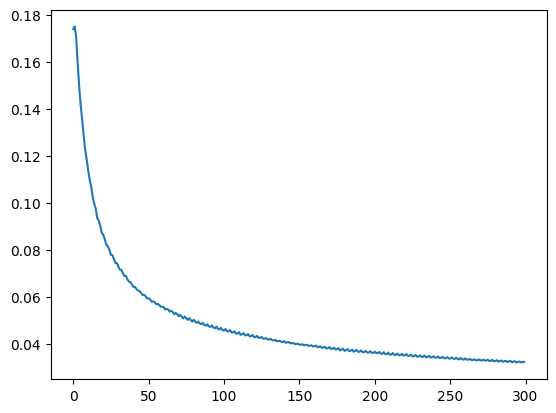

In [20]:
plt.plot(loss_list)

In [21]:
accuracy(train_set)

0.83895

In [187]:
Xpr = mat['Xvr']

In [188]:
y_predict_ = predict_new3(X_to_predict)

predicted - 6


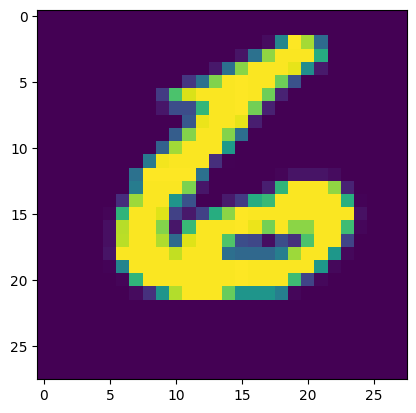

In [191]:
num = -1
print(f'predicted - {np.argmax(y_predict_[num])}')
plt.imshow(Xpr[num].reshape(28,28))
plt.show()

In [171]:
X_to_predict_array = X_to_predict.values
X_to_predict_array.shape

(10000, 784)

In [172]:
y_predict = []
for i in range(len(X_to_predict_array)):
    y_predict.append(np.argmax(predict_new3(X_to_predict_array[i].reshape(1,-1))))

In [173]:
y_predict_new = [y_predict[i]*100+1 for i in range(len(y_predict))]

In [174]:
y_predict_new_df = pd.DataFrame(np.array(y_predict_new))

In [175]:
y_predict_new_df

,0
0,701
1,201
2,101
3,1
4,401
...,...
9995,201
9996,301
9997,401
9998,501


In [194]:
df_ = pd.read_csv('solmnist_exc.csv')

In [196]:
y_predict_new_df['id'] = df_.id
y_predict_new_df['class'] = y_predict_new_df.iloc[:,0]
y_predict_new_df.rename(columns = {0: 'class'}, inplace = True)
y_predict_new_df = y_predict_new_df[['id', 'class']]
y_predict_new_df = y_predict_new_df.iloc[:,:-1]
y_predict_new_df

,id,class
0,1,701
1,2,201
2,3,101
3,4,1
4,5,401
...,...,...
9995,9996,201
9996,9997,301
9997,9998,401
9998,9999,501


In [197]:
y_predict_new_df.to_csv('Skripkin_mnist.csv', index = False)

In [68]:
class NeuralNet:

    def __init__(self, h_size1, h_size2,train_set, batch_size = None, learn_rate = 0.00001):
        random.shuffle(train_set)
        self.input_size = train_set[0][0].shape[1]
        self.output_size = train_set[0][1].shape[1]
        self.h_size1 = h_size1
        self.h_size2 = h_size2
        self.train_set = train_set
        self.learn_rate = learn_rate
        if batch_size is not None:
            self.batch_size = batch_size
        else:
            self.batch_size = len(train_set)

        self.w1 = np.random.randn(self.input_size, h_size1)
        self.b1 = np.random.randn(1, h_size1)

        self.w2 = np.random.randn(h_size1, h_size2)
        self.b2 = np.random.randn(1, h_size2)

        self.w3 = np.random.randn(h_size2, self.output_size)
        self.b3 = np.random.randn(1, self.output_size)

        self.n_iters = len(train_set) // self.batch_size

        self.s1 = 0
        self.h1 = 0

        self.h2 = 0
        self.s2 = 0

        self.s3 = 0
        self.h3 = 0

        self.z = 0

    def relu_deriv(self,t):
    
        return (t >= 0).astype(float)

    def relu(self,t):
        return np.maximum(t,0)

    def stable_softmax(self,x):
        z = x - np.max(x, axis = 1, keepdims = True)
        numerator = np.exp(z)
        denominator = np.sum(numerator, axis = 1, keepdims = True)
        softmax = numerator/denominator
        return softmax


    def forward(self,x):
        self.s1 = np.dot(x, self.w1) + self.b1
#         print(f's1 - {self.s1.shape}')

        self.h1 = self.relu(self.s1)
#         print(f'h1 - {self.h1.shape}')

        self.s2 = np.dot(self.h1, self.w2) + self.b2
#         print(f's2 - {self.s2.shape}')
        
        self.h2 = self.relu(self.s2)
#         print(f'h2 - {self.h2.shape}')

        self.s3 = np.dot(self.h2, self.w3) + self.b3
#         print(f's3 - {self.s3.shape}')

        self.z = self.stable_softmax(self.s3)
#         print(f'z - {self.z.shape}')

        return self.z

    def backward(self,x,y):

        #3 layer

        dloss_dS3  = 2*(self.z - y)/self.batch_size  
#         print(f'dloss_dS3 - {dloss_dS3.shape}')

        dloss_dW3 = self.h2.T @ dloss_dS3
#         print(f'dloss_dW3 - {dloss_dW3.shape}')

        dloss_db3 = np.sum(dloss_dS3, axis = 0, keepdims = True)
#         print(f'dloss_db3 - {dloss_db3.shape}')

        dloss_dh2 = dloss_dS3 @ self.w3.T
#         print(f'dloss_dh2 - {dloss_dh2.shape}')

#         print(f's2 - {self.s2.shape}')
#         print(f'relu-deriv - {self.relu_deriv(self.s2).shape}')
        # 2 layer
 
        dloss_dS2  = dloss_dh2 * (self.relu_deriv(self.s2)) 
        
        dloss_dW2 = self.h1.T @ dloss_dS2
        
        dloss_db2 = np.sum(dloss_dS2, axis = 0, keepdims = True)
        
        dloss_dh1 = dloss_dS2 @ self.w2.T
        
        # 1 layer
        dloss_dS1  = dloss_dh1*self.relu_deriv(self.s1)
        
        dloss_dW1 = x.T @ dloss_dS1
        
        dloss_db1 = np.sum(dloss_dS1, axis = 0, keepdims=True)
        
        self.w1 = self.w1 - self.learn_rate *dloss_dW1
        self.b1 = self.b1 - self.learn_rate *dloss_db1
        
        self.w2 = self.w2 - self.learn_rate *dloss_dW2
        self.b2 = self.b2 - self.learn_rate *dloss_db2

        self.w3 = self.w3 - self.learn_rate *dloss_dW3
        self.b3 = self.b3 - self.learn_rate *dloss_db3


    def parameters(self):

        return self.w1, self.b1, self.w2, self.b2,self.w3, self.b3

    def loss_batch(self, y):
    
        return np.mean(np.mean(((y-self.z)**2), axis = 1))


  



In [69]:
n = NeuralNet(392,100, train_set, batch_size = 100)

In [79]:
n_epochs = 40
for ep in range(1):

    for i in range(1):
        X,y = n.train_set[i]
        n.forward(X)
        print(f'ep: {ep+1}/{n_epochs}, i: {i+1}/{n.n_iters}, '
              f'loss - {n.loss_batch(y):.3f}, ')
        n.backward(X,y)

ep: 1/40, i: 1/600, loss - 0.200, 
